In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pdb
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS

# Notebook with simple experiments

## Task 1

### Receiving of the true $\theta$ and generating of a dataset

In [2]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"

z_dim = 2 # Latent space dimensionality
data_dim = 10 # Data dimensionality
N = 1000 # Dataset size

sigma_0 = 1. # True std

In [3]:
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
std_normal_pyro = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
true_theta = std_normal.sample((z_dim, data_dim)) * sigma_0
print('True decoder matrix')
print(true_theta)
print('-' * 100)

data_probs = torch.sigmoid(std_normal.sample((N, z_dim)) @ true_theta)
data = torch.distributions.Bernoulli(probs=data_probs).sample()

print('Generated data example:')
print(data[:10])

True decoder matrix
tensor([[-0.2395, -1.6117, -0.8419,  1.1348,  2.0077, -1.7586, -1.0571, -0.9721,
         -0.9768, -0.6460],
        [-0.4009,  1.0705,  0.2836, -0.8892,  0.0182, -0.7025, -0.3824,  0.9846,
         -0.0543,  0.5529]], device='cuda:1')
----------------------------------------------------------------------------------------------------
Generated data example:
tensor([[0., 1., 1., 1., 1., 0., 0., 0., 1., 1.],
        [1., 1., 1., 0., 0., 1., 1., 1., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 1., 0.],
        [1., 1., 1., 0., 1., 1., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 1., 0., 1.],
        [0., 1., 1., 0., 1., 1., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 1., 0., 1., 0.]], device='cuda:1')


## Task 2

### Sample z with target $p(z|x)$, using HMC (NUTS)

#### 1) Bernoulli likelihood from torch

In [4]:
n_warmup = 1000
n_samples = 1

In [5]:
def potential_fn(z):
    z = z['points']
    probs = torch.sigmoid(z @ true_theta)
    return -torch.mean(pyro.distributions.Bernoulli(probs=probs).log_prob(data).sum(1) + std_normal_pyro.log_prob(z).sum(1))

In [6]:
init_samples = std_normal_pyro.sample((data.shape[0], z_dim))
init_params = {'points': init_samples}

nuts_kernel = NUTS(potential_fn=potential_fn)
mcmc = MCMC(nuts_kernel,
            initial_params=init_params,
            num_samples=n_samples,
            warmup_steps=n_warmup)

mcmc.run()
z = mcmc.get_samples()['points'].squeeze()

Sample: 100%|██████████| 1001/1001 [00:59, 16.89it/s, step size=1.94e-01, acc. prob=0.526]


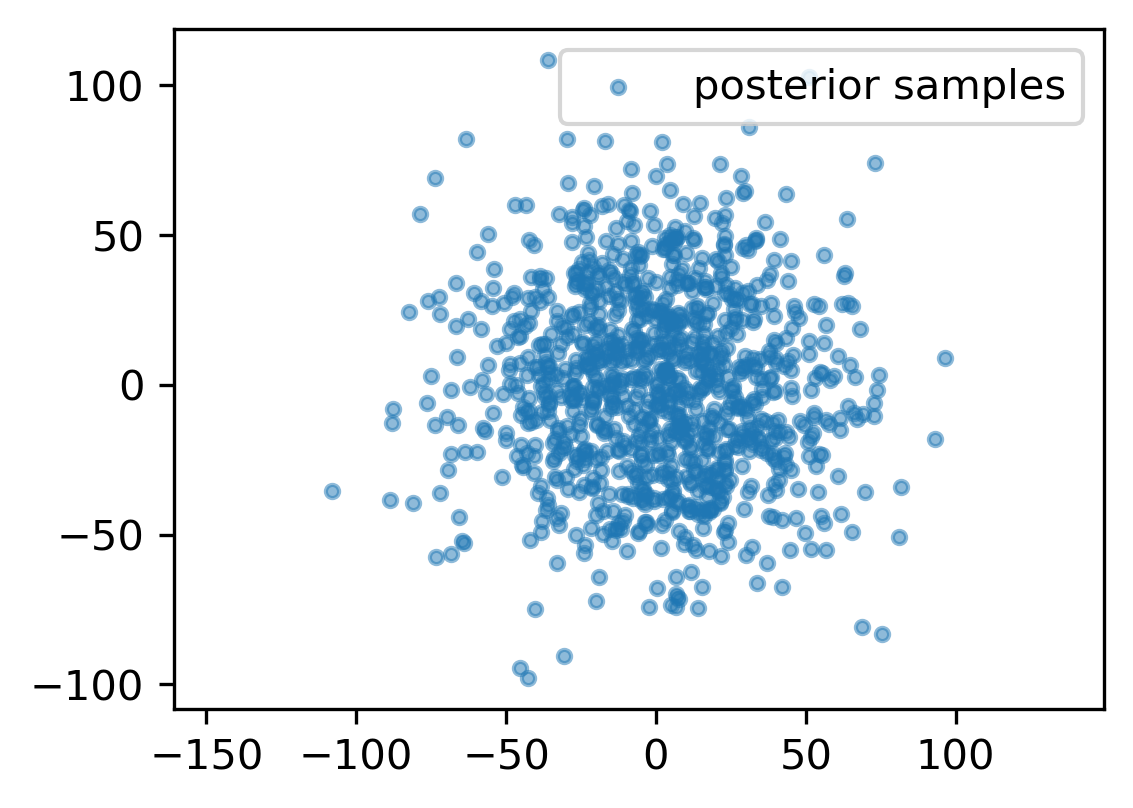

In [7]:
plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), label='posterior samples', s=10, alpha=0.5)
plt.legend()
plt.axis('equal');

#### 2) Using simplified likelihood

In [8]:
def potential_fn(z):
    z = z['points']
    prod = z @ true_theta
    potential = -data * prod + torch.log(1. + torch.exp(prod))
    return potential.sum()

In [9]:
init_samples = std_normal_pyro.sample((data.shape[0], z_dim))
init_params = {'points': init_samples}

nuts_kernel = NUTS(potential_fn=potential_fn)
mcmc = MCMC(nuts_kernel,
            initial_params=init_params,
            num_samples=n_samples,
            warmup_steps=n_warmup)

mcmc.run()
z = mcmc.get_samples()['points'].squeeze()

Sample: 100%|██████████| 1001/1001 [00:19, 52.53it/s, step size=3.51e-02, acc. prob=0.914]


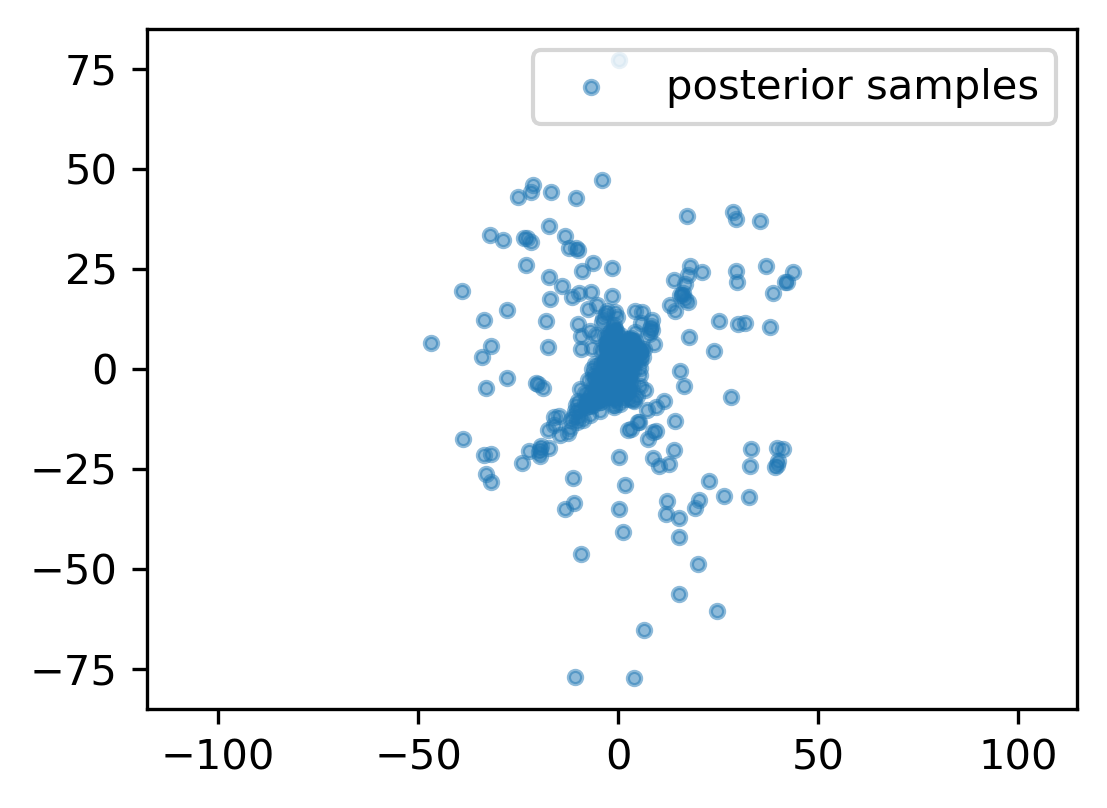

In [10]:
plt.figure(figsize=(4, 3), dpi=300)
plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), label='posterior samples', s=10, alpha=0.5)
plt.legend()
plt.axis('equal');

## Task 3

#### Fisher's identity

In [11]:
class Decoder(nn.Module):
    def __init__(self, data_dim, z_dim):
        super(Decoder, self).__init__()
        self.W = nn.Linear(in_features=z_dim, out_features=data_dim, bias=False)
    def forward(self, z):
        return self.W(z)

In [12]:
num_epoches = 10
batch_size = 250
n_samples = 10
n_warmup = 100

print_info_ = 1

In [13]:
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

In [14]:
dec = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(params=dec.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max')

In [15]:
def potential_fn(z):
    z = z['points']
    probs = torch.sigmoid(z @ current_matrix)
    return -torch.mean(pyro.distributions.Bernoulli(probs=probs).log_prob(batch_train).sum(1) + std_normal_pyro.log_prob(z).sum(1))

In [16]:
for ep in tqdm(range(num_epoches)): # cycle over epoches
    plt.close()
    j = 0
    obj_sum = 0
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
        
        init_samples = std_normal.sample((batch_train.shape[0], z_dim))
        init_params = {'points': init_samples}
        
        current_matrix = dec.W.weight.detach().T
        
        nuts_kernel = NUTS(potential_fn=potential_fn)
        mcmc = MCMC(nuts_kernel,
                    initial_params=init_params,
                    num_samples=n_samples,
                    warmup_steps=n_warmup)
        mcmc.run()
        z = mcmc.get_samples()['points'][-n_samples:]
        
#         pdb.set_trace()
        
        probs = torch.sigmoid(dec(z))
        obj = torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean(0).sum(1).mean()

        (-obj).backward()
        optimizer.step()
        optimizer.zero_grad()
        
        j += 1
        obj_sum += obj.cpu().detach().numpy()
#     scheduler.step(obj)
    if ep % print_info_ == 0:
        print('obj:', obj.cpu().detach().item())

Warmup:   3%|▎         | 3/110 [00:00, 25.40it/s, step size=7.56e-01, acc. prob=0.304]

obj: -32.29640197753906


Warmup:   3%|▎         | 3/110 [00:00, 19.13it/s, step size=1.42e+00, acc. prob=0.383]

obj: -32.834110260009766


Warmup:   0%|          | 0/110 [00:00, ?it/s]]

obj: -31.866872787475586


Warmup:   3%|▎         | 3/110 [00:00, 17.93it/s, step size=8.99e-01, acc. prob=0.325]

obj: -32.3828010559082


Warmup:   3%|▎         | 3/110 [00:00, 28.80it/s, step size=7.89e-01, acc. prob=0.309]

obj: -32.09992218017578


Warmup:   3%|▎         | 3/110 [00:00, 18.15it/s, step size=8.77e-01, acc. prob=0.322]

obj: -32.368247985839844


Warmup:   3%|▎         | 3/110 [00:00, 20.56it/s, step size=9.32e-01, acc. prob=0.330]

obj: -31.263376235961914


Warmup:   3%|▎         | 3/110 [00:00, 19.59it/s, step size=1.18e+00, acc. prob=0.359]

obj: -31.223430633544922


Warmup:   3%|▎         | 3/110 [00:00, 21.70it/s, step size=7.52e-01, acc. prob=0.303]

obj: -32.701053619384766


100%|██████████| 10/10 [02:50<00:00, 17.07s/it]

obj: -31.397205352783203


In [17]:
print('true_theta', true_theta)
print('-' * 100)
print(dec.W.weight.detach().T)

true_theta tensor([[-0.2395, -1.6117, -0.8419,  1.1348,  2.0077, -1.7586, -1.0571, -0.9721,
         -0.9768, -0.6460],
        [-0.4009,  1.0705,  0.2836, -0.8892,  0.0182, -0.7025, -0.3824,  0.9846,
         -0.0543,  0.5529]], device='cuda:1')
----------------------------------------------------------------------------------------------------
tensor([[-0.6226, -0.0220, -0.5035,  0.6921,  0.0227,  0.1604,  0.6775, -0.1529,
         -0.0709,  0.4929],
        [-0.6337, -0.2611,  0.3393, -0.6581,  0.5113, -0.4406,  0.4557, -0.2515,
          0.2851,  0.0442]], device='cuda:1')


## Task 4

### Simple VAE

In [18]:
class Encoder_vae(nn.Module):
    def __init__(self, data_dim, z_dim, K):
        super(Encoder_vae, self).__init__()
        self.h1 = nn.Linear(in_features=data_dim, out_features=K)
        self.h2 = nn.Linear(in_features=K, out_features=K)
        self.mu = nn.Linear(in_features=K, out_features=z_dim)
        self.sigma = nn.Linear(in_features=K, out_features=z_dim)
    def forward(self, x):
        h1 = F.selu(self.h1(x))
        h2 = F.selu(self.h2(h1))
        return self.mu(h2), F.softplus(self.sigma(h2))

In [19]:
K = 1024
num_epoches = 5000
batch_size = 250
n_samples = 10
n_warmup = 100
print_info_ = 500

enc = Encoder_vae(data_dim=data_dim, z_dim=z_dim, K=K).to(device)
dec = Decoder(data_dim=data_dim, z_dim=z_dim).to(device)

params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params=params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max')

In [20]:
for ep in tqdm(range(num_epoches)): # cycle over epoches
    plt.close()
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
        mu, sigma = enc(batch_train) # sample mu and sigma from encoder
        u = std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + u * sigma # reperametrization trick
        
        prod = dec(z)
        log_likelihood = torch.distributions.Bernoulli(probs=torch.sigmoid(prod)).log_prob(batch_train).sum(1)

        KLD = -0.5 * torch.mean(1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))
        elbo = torch.mean(log_likelihood - KLD)
        (-elbo).backward()
        
        optimizer.step()
        optimizer.zero_grad()
#     scheduler.step(elbo)
    if ep % print_info_ == 0:
        print('elbo:', elbo.cpu().detach().item())

  0%|          | 7/5000 [00:00<01:11, 69.43it/s]

elbo: -6.957396984100342


 10%|█         | 515/5000 [00:06<00:55, 80.70it/s]

elbo: -6.137938976287842


 20%|██        | 1010/5000 [00:12<00:49, 80.70it/s]

elbo: -5.884395122528076


 30%|███       | 1514/5000 [00:18<00:43, 80.68it/s]

elbo: -5.883743762969971


 40%|████      | 2009/5000 [00:24<00:37, 80.65it/s]

elbo: -5.682383060455322


 50%|█████     | 2513/5000 [00:31<00:30, 80.67it/s]

elbo: -5.922156810760498


 60%|██████    | 3017/5000 [00:37<00:24, 80.60it/s]

elbo: -5.8645830154418945


 70%|███████   | 3512/5000 [00:43<00:18, 80.63it/s]

elbo: -5.806591033935547


 80%|████████  | 4009/5000 [00:49<00:12, 79.59it/s]

elbo: -5.874019622802734


 90%|█████████ | 4513/5000 [00:56<00:06, 79.58it/s]

elbo: -5.65908145904541


100%|██████████| 5000/5000 [01:02<00:00, 80.34it/s]


In [21]:
print('true_theta', true_theta)
print('-' * 100)
print(dec.W.weight.detach().T)

true_theta tensor([[-0.2395, -1.6117, -0.8419,  1.1348,  2.0077, -1.7586, -1.0571, -0.9721,
         -0.9768, -0.6460],
        [-0.4009,  1.0705,  0.2836, -0.8892,  0.0182, -0.7025, -0.3824,  0.9846,
         -0.0543,  0.5529]], device='cuda:1')
----------------------------------------------------------------------------------------------------
tensor([[ 3.8429,  0.7568,  0.8197, -0.8022, -2.1721,  1.8505,  0.9174,  0.4271,
          0.8027,  0.3145],
        [ 3.0314, -3.1894, -0.7754,  1.4053,  1.2717, -0.3308, -0.1881, -1.1567,
         -0.5434, -0.8052]], device='cuda:1')
